In [5]:
!fusermount -u /content/drive


from google.colab import drive
drive.mount('/content/drive')

fusermount: failed to unmount /content/drive: No such file or directory
Mounted at /content/drive


In [6]:
import os
import pandas as pd
import numpy as np
import glob
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import ast

In [7]:
# helpers
def clean_stringified_list(df):
  print(">>> clean stringified")
  for col in df.columns:
    if df[col].dtype == 'object':
      df[col] = df[col].astype(str).str.strip("[]").str.strip("'").str.strip('"')
  return df

def drop_nonNumeric_and_year(df):
  print(">>>> clean nonnumerics")
  return df.select_dtypes(include=[np.number])

In [8]:
# read + process, using threadding

# --------------------- csv cleaning functions ---------------------
def read_and_clean(input_path):
  print(f"Reading {input_path} louise")
  try:
    print(f"Reading {input_path}")
    df = pd.read_csv(input_path, sep=',', low_memory=False)
    df = clean_stringified_list(df)
    df['source_file'] = os.path.basename(input_path)
    print(f" ---------- Finished reading {input_path}")
    return df
  except Exception as e:
    print(f" Error reading {input_path}: {e}")
    return pd.DataFrame() # returning empty df

# --------------------- threadding based csv read ---------------------
def thread_read_and_clean(IN_DIR, limit=None):
  all_files = glob.glob(os.path.join(IN_DIR, '*.csv'))
  if limit:
    all_files = all_files[:limit]
  with ThreadPoolExecutor() as executor:
    dfs = list(tqdm(executor.map(read_and_clean, all_files)))
  # sampling will happening in the consequence of this function
  combined = pd.concat(dfs, ignore_index=True)
  return combined

# --------------------- sample slection ---------------------
def sample_data(df, n):
  out_df = df.sample(n=n, random_state=42).reset_index(drop=True)
  print(f"SAMPLE leewks like {out_df.head(2)}")
  return out_df

# --------------------- fetching only probability columns ---------------------
def get_prob_cols(df):
  x_cols = [col for col in df.columns if col.endswith('_probability')]
  x_df = df[x_cols].apply(pd.to_numeric, errors='coerce')
  return x_df

In [9]:
# clustering functions

# --------------------- KMEANS ---------------------
def run_kmeans(X, n_clusters=5):
  model = KMeans(n_clusters=n_clusters, random_state=42)
  labels = model.fit_predict(X)
  return labels

# --------------------- DBSCAN ---------------------
def run_dbscan(X, eps=0.5, min_samples=5):
  model = DBSCAN(eps=eps, min_samples=min_samples)
  labels = model.fit_predict(X)
  return labels
# --------------------- GAUSSIAN ---------------------
def run_gmm(X, n_components=5):
  model = GaussianMixture(n_components=n_components, random_state=42)
  labels = model.fit_predict(X)
  return labels

# cluster decoding
# --------------------- genre get ---------------------
def get_genre(df):
  genre_cols = [c for c in df.columns if "genre_" in c and c.endswith("_value")]
  genres = df[genre_cols].mode(axis=1)[0].str.lower().str.strip()
  return genres

# -------------------- generalize genres ---------------
def simplify_genre(g):
    if pd.isna(g): return "unknown"
    if "jazz" in g: return "jazz"
    if "electronic" in g or "trance" in g or "techno" in g: return "electronic"
    if "rock" in g: return "rock"
    if "pop" in g: return "pop"
    if "hip" in g or "rap" in g: return "hiphop"
    return "other"

In [10]:
# --------------------- plotting function (vis) ---------------------
def plot_cluster(cluster_labels, years, title=''):
  df = pd.DataFrame({'cluster': cluster_labels, 'year': years})
  df.sort_values(by='year', inplace=True)
  plt.figure(figsize=(10, 6))
  sns.countplot(data=df, x="year", hue="cluster")
  plt.title(title)
  plt.show()

In [11]:
# --------------------- pipeline fucntion ---------------------
# since there is so much going on,
# its better to modularize as much as we can, and stitch it together
# so as to make debugging easier
def pipelinee(df, sample_size):
    samplee = sample_data(df, sample_size)
    # genre clean and pre decode
    samplee["BIG_GENRE"] = get_genre(samplee).apply(simplify_genre)

    years = samplee.get('metadata_tags_originaldate', pd.Series([np.nan]*len(samplee)))
    # get years, only year no date stuff, clean up
    years = years.str.extract(r'(\d{4})')[0]
    # years = years.dropna()

    # get feature columns (probability for now)
    X = get_prob_cols(samplee)
    X_scaled = StandardScaler().fit_transform(X)

    clusters_kmeans = run_kmeans(X_scaled)
    clusters_dbscan = run_dbscan(X_scaled)
    clusters_gmm = run_gmm(X_scaled)

    plot_cluster(clusters_kmeans, years, title=f"KMeans - {sample_size} samples")
    X_clustered = pd.DataFrame(X_scaled, columns=X.columns)
    X_clustered['cluster'] = clusters_kmeans
    print("-------------------- KMEANS Cluster AVG ----------------- ")
    print(X_clustered.groupby('cluster').mean().round(2))
    plot_cluster(clusters_dbscan, years, title=f"DBSCAN - {sample_size} samples")
    plot_cluster(clusters_gmm, years, title=f"GMM - {sample_size} samples")


In [12]:
CSV_DIR = "/content/drive/MyDrive/music_anthro_M2/acousticbrainz/filteredABfiles_jun24/"

Reading /content/drive/MyDrive/music_anthro_M2/acousticbrainz/filteredABfiles_jun24/csv_chunk_06__18.csv louise
Reading /content/drive/MyDrive/music_anthro_M2/acousticbrainz/filteredABfiles_jun24/csv_chunk_06__18.csv
Reading /content/drive/MyDrive/music_anthro_M2/acousticbrainz/filteredABfiles_jun24/csv_chunk_06__8.csv louise
Reading /content/drive/MyDrive/music_anthro_M2/acousticbrainz/filteredABfiles_jun24/csv_chunk_06__8.csv
Reading /content/drive/MyDrive/music_anthro_M2/acousticbrainz/filteredABfiles_jun24/csv_chunk_06__15.csv louise
Reading /content/drive/MyDrive/music_anthro_M2/acousticbrainz/filteredABfiles_jun24/csv_chunk_06__15.csv
Reading /content/drive/MyDrive/music_anthro_M2/acousticbrainz/filteredABfiles_jun24/csv_chunk_06__13.csv louise
Reading /content/drive/MyDrive/music_anthro_M2/acousticbrainz/filteredABfiles_jun24/csv_chunk_06__13.csv
Reading /content/drive/MyDrive/music_anthro_M2/acousticbrainz/filteredABfiles_jun24/csv_chunk_06__12.csv louise
Reading /content/drive

0it [00:00, ?it/s]

>>> clean stringified
>>> clean stringified
>>> clean stringified
>>> clean stringified
>>> clean stringified
>>> clean stringified
>>> clean stringified
>>> clean stringified
>>> clean stringified
>>> clean stringified
 ---------- Finished reading /content/drive/MyDrive/music_anthro_M2/acousticbrainz/filteredABfiles_jun24/csv_chunk_06__16.csv
Reading /content/drive/MyDrive/music_anthro_M2/acousticbrainz/filteredABfiles_jun24/csv_chunk_06__2.csv louise
Reading /content/drive/MyDrive/music_anthro_M2/acousticbrainz/filteredABfiles_jun24/csv_chunk_06__2.csv
>>> clean stringified
 ---------- Finished reading /content/drive/MyDrive/music_anthro_M2/acousticbrainz/filteredABfiles_jun24/csv_chunk_06__13.csv
Reading /content/drive/MyDrive/music_anthro_M2/acousticbrainz/filteredABfiles_jun24/csv_chunk_06__5.csv louise
Reading /content/drive/MyDrive/music_anthro_M2/acousticbrainz/filteredABfiles_jun24/csv_chunk_06__5.csv
 ---------- Finished reading /content/drive/MyDrive/music_anthro_M2/acoustic

1it [00:27, 27.43s/it]

 ---------- Finished reading /content/drive/MyDrive/music_anthro_M2/acousticbrainz/filteredABfiles_jun24/csv_chunk_06__18.csv
Reading /content/drive/MyDrive/music_anthro_M2/acousticbrainz/filteredABfiles_jun24/csv_chunk_06__11.csv louise
Reading /content/drive/MyDrive/music_anthro_M2/acousticbrainz/filteredABfiles_jun24/csv_chunk_06__11.csv
>>> clean stringified
 ---------- Finished reading /content/drive/MyDrive/music_anthro_M2/acousticbrainz/filteredABfiles_jun24/csv_chunk_06__6.csv
Reading /content/drive/MyDrive/music_anthro_M2/acousticbrainz/filteredABfiles_jun24/csv_chunk_06__3.csv louise
Reading /content/drive/MyDrive/music_anthro_M2/acousticbrainz/filteredABfiles_jun24/csv_chunk_06__3.csv
 ---------- Finished reading /content/drive/MyDrive/music_anthro_M2/acousticbrainz/filteredABfiles_jun24/csv_chunk_06__15.csv
Reading /content/drive/MyDrive/music_anthro_M2/acousticbrainz/filteredABfiles_jun24/csv_chunk_06__7.csv louise
Reading /content/drive/MyDrive/music_anthro_M2/acousticbra

2it [00:29, 12.50s/it]

 ---------- Finished reading /content/drive/MyDrive/music_anthro_M2/acousticbrainz/filteredABfiles_jun24/csv_chunk_06__8.csv
Reading /content/drive/MyDrive/music_anthro_M2/acousticbrainz/filteredABfiles_jun24/csv_chunk_01__12.csv louise
Reading /content/drive/MyDrive/music_anthro_M2/acousticbrainz/filteredABfiles_jun24/csv_chunk_01__12.csv


8it [00:30,  2.15s/it]

 ---------- Finished reading /content/drive/MyDrive/music_anthro_M2/acousticbrainz/filteredABfiles_jun24/csv_chunk_06__9.csv
Reading /content/drive/MyDrive/music_anthro_M2/acousticbrainz/filteredABfiles_jun24/csv_chunk_01__16.csv louise
Reading /content/drive/MyDrive/music_anthro_M2/acousticbrainz/filteredABfiles_jun24/csv_chunk_01__16.csv
>>> clean stringified
>>> clean stringified
>>> clean stringified
>>> clean stringified
>>> clean stringified
>>> clean stringified
>>> clean stringified>>> clean stringified



13it [00:36,  1.72s/it]

>>> clean stringified
 ---------- Finished reading /content/drive/MyDrive/music_anthro_M2/acousticbrainz/filteredABfiles_jun24/csv_chunk_06__2.csv
Reading /content/drive/MyDrive/music_anthro_M2/acousticbrainz/filteredABfiles_jun24/csv_chunk_01__18.csv louise
Reading /content/drive/MyDrive/music_anthro_M2/acousticbrainz/filteredABfiles_jun24/csv_chunk_01__18.csv
>>> clean stringified
>>> clean stringified
 ---------- Finished reading /content/drive/MyDrive/music_anthro_M2/acousticbrainz/filteredABfiles_jun24/csv_chunk_06__14.csv
Reading /content/drive/MyDrive/music_anthro_M2/acousticbrainz/filteredABfiles_jun24/csv_chunk_01__10.csv louise
Reading /content/drive/MyDrive/music_anthro_M2/acousticbrainz/filteredABfiles_jun24/csv_chunk_01__10.csv


14it [00:38,  1.79s/it]

 ---------- Finished reading /content/drive/MyDrive/music_anthro_M2/acousticbrainz/filteredABfiles_jun24/csv_chunk_06__5.csv
Reading /content/drive/MyDrive/music_anthro_M2/acousticbrainz/filteredABfiles_jun24/csv_chunk_01__6.csv louise
Reading /content/drive/MyDrive/music_anthro_M2/acousticbrainz/filteredABfiles_jun24/csv_chunk_01__6.csv
>>> clean stringified
 ---------- Finished reading /content/drive/MyDrive/music_anthro_M2/acousticbrainz/filteredABfiles_jun24/csv_chunk_06__3.csv
Reading /content/drive/MyDrive/music_anthro_M2/acousticbrainz/filteredABfiles_jun24/csv_chunk_01__7.csv louise
Reading /content/drive/MyDrive/music_anthro_M2/acousticbrainz/filteredABfiles_jun24/csv_chunk_01__7.csv
 ---------- Finished reading /content/drive/MyDrive/music_anthro_M2/acousticbrainz/filteredABfiles_jun24/csv_chunk_06__19.csv
Reading /content/drive/MyDrive/music_anthro_M2/acousticbrainz/filteredABfiles_jun24/csv_chunk_01__19.csv louise
Reading /content/drive/MyDrive/music_anthro_M2/acousticbrain

16it [00:42,  1.71s/it]

 ---------- Finished reading /content/drive/MyDrive/music_anthro_M2/acousticbrainz/filteredABfiles_jun24/csv_chunk_06__10.csv
Reading /content/drive/MyDrive/music_anthro_M2/acousticbrainz/filteredABfiles_jun24/csv_chunk_01__2.csv louise
Reading /content/drive/MyDrive/music_anthro_M2/acousticbrainz/filteredABfiles_jun24/csv_chunk_01__2.csv
 ---------- Finished reading /content/drive/MyDrive/music_anthro_M2/acousticbrainz/filteredABfiles_jun24/csv_chunk_06__11.csv
Reading /content/drive/MyDrive/music_anthro_M2/acousticbrainz/filteredABfiles_jun24/csv_chunk_01__4.csv louise
Reading /content/drive/MyDrive/music_anthro_M2/acousticbrainz/filteredABfiles_jun24/csv_chunk_01__4.csv
 ---------- Finished reading /content/drive/MyDrive/music_anthro_M2/acousticbrainz/filteredABfiles_jun24/csv_chunk_01__13.csv
Reading /content/drive/MyDrive/music_anthro_M2/acousticbrainz/filteredABfiles_jun24/csv_chunk_01__17.csv louise
Reading /content/drive/MyDrive/music_anthro_M2/acousticbrainz/filteredABfiles_ju

18it [00:42,  1.19s/it]

 ---------- Finished reading /content/drive/MyDrive/music_anthro_M2/acousticbrainz/filteredABfiles_jun24/csv_chunk_06__7.csv
Reading /content/drive/MyDrive/music_anthro_M2/acousticbrainz/filteredABfiles_jun24/csv_chunk_01__20.csv louise
Reading /content/drive/MyDrive/music_anthro_M2/acousticbrainz/filteredABfiles_jun24/csv_chunk_01__20.csv
 ---------- Finished reading /content/drive/MyDrive/music_anthro_M2/acousticbrainz/filteredABfiles_jun24/csv_chunk_01__11.csv
Reading /content/drive/MyDrive/music_anthro_M2/acousticbrainz/filteredABfiles_jun24/csv_chunk_01__3.csv louise
Reading /content/drive/MyDrive/music_anthro_M2/acousticbrainz/filteredABfiles_jun24/csv_chunk_01__3.csv


23it [00:43,  1.54it/s]

 ---------- Finished reading /content/drive/MyDrive/music_anthro_M2/acousticbrainz/filteredABfiles_jun24/csv_chunk_01__12.csv
Reading /content/drive/MyDrive/music_anthro_M2/acousticbrainz/filteredABfiles_jun24/csv_chunk_01__15.csv louise
Reading /content/drive/MyDrive/music_anthro_M2/acousticbrainz/filteredABfiles_jun24/csv_chunk_01__15.csv
>>> clean stringified


25it [00:46,  1.18it/s]

>>> clean stringified
 ---------- Finished reading /content/drive/MyDrive/music_anthro_M2/acousticbrainz/filteredABfiles_jun24/csv_chunk_01__18.csv
Reading /content/drive/MyDrive/music_anthro_M2/acousticbrainz/filteredABfiles_jun24/csv_chunk_01__1.csv louise
Reading /content/drive/MyDrive/music_anthro_M2/acousticbrainz/filteredABfiles_jun24/csv_chunk_01__1.csv
>>> clean stringified
>>> clean stringified
>>> clean stringified
>>> clean stringified
 ---------- Finished reading /content/drive/MyDrive/music_anthro_M2/acousticbrainz/filteredABfiles_jun24/csv_chunk_01__17.csv
Reading /content/drive/MyDrive/music_anthro_M2/acousticbrainz/filteredABfiles_jun24/csv_chunk_01__8.csv louise
Reading /content/drive/MyDrive/music_anthro_M2/acousticbrainz/filteredABfiles_jun24/csv_chunk_01__8.csv


26it [00:50,  1.34s/it]

 ---------- Finished reading /content/drive/MyDrive/music_anthro_M2/acousticbrainz/filteredABfiles_jun24/csv_chunk_01__10.csv
Reading /content/drive/MyDrive/music_anthro_M2/acousticbrainz/filteredABfiles_jun24/csv_chunk_01__14.csv louise
Reading /content/drive/MyDrive/music_anthro_M2/acousticbrainz/filteredABfiles_jun24/csv_chunk_01__14.csv
>>> clean stringified
>>> clean stringified ---------- Finished reading /content/drive/MyDrive/music_anthro_M2/acousticbrainz/filteredABfiles_jun24/csv_chunk_01__19.csv
Reading /content/drive/MyDrive/music_anthro_M2/acousticbrainz/filteredABfiles_jun24/csv_chunk_01__9.csv louise
Reading /content/drive/MyDrive/music_anthro_M2/acousticbrainz/filteredABfiles_jun24/csv_chunk_01__9.csv

>>> clean stringified
 ---------- Finished reading /content/drive/MyDrive/music_anthro_M2/acousticbrainz/filteredABfiles_jun24/csv_chunk_01__20.csv
Reading /content/drive/MyDrive/music_anthro_M2/acousticbrainz/filteredABfiles_jun24/csv_chunk_02__2.csv louise
Reading /cont

27it [00:54,  1.71s/it]

>>> clean stringified ---------- Finished reading /content/drive/MyDrive/music_anthro_M2/acousticbrainz/filteredABfiles_jun24/csv_chunk_01__6.csv
Reading /content/drive/MyDrive/music_anthro_M2/acousticbrainz/filteredABfiles_jun24/csv_chunk_02__13.csv louise
Reading /content/drive/MyDrive/music_anthro_M2/acousticbrainz/filteredABfiles_jun24/csv_chunk_02__13.csv

 ---------- Finished reading /content/drive/MyDrive/music_anthro_M2/acousticbrainz/filteredABfiles_jun24/csv_chunk_01__15.csv
Reading /content/drive/MyDrive/music_anthro_M2/acousticbrainz/filteredABfiles_jun24/csv_chunk_02__14.csv louise
Reading /content/drive/MyDrive/music_anthro_M2/acousticbrainz/filteredABfiles_jun24/csv_chunk_02__14.csv
>>> clean stringified
 ---------- Finished reading /content/drive/MyDrive/music_anthro_M2/acousticbrainz/filteredABfiles_jun24/csv_chunk_01__5.csv
Reading /content/drive/MyDrive/music_anthro_M2/acousticbrainz/filteredABfiles_jun24/csv_chunk_02__5.csv louise
Reading /content/drive/MyDrive/musi

29it [00:58,  1.66s/it]

 ---------- Finished reading /content/drive/MyDrive/music_anthro_M2/acousticbrainz/filteredABfiles_jun24/csv_chunk_01__7.csv
Reading /content/drive/MyDrive/music_anthro_M2/acousticbrainz/filteredABfiles_jun24/csv_chunk_02__4.csv louise
Reading /content/drive/MyDrive/music_anthro_M2/acousticbrainz/filteredABfiles_jun24/csv_chunk_02__4.csv
>>> clean stringified
>>> clean stringified
>>> clean stringified
>>> clean stringified
>>> clean stringified
>>> clean stringified


31it [01:04,  2.19s/it]

 ---------- Finished reading /content/drive/MyDrive/music_anthro_M2/acousticbrainz/filteredABfiles_jun24/csv_chunk_01__2.csv
Reading /content/drive/MyDrive/music_anthro_M2/acousticbrainz/filteredABfiles_jun24/csv_chunk_02__3.csv louise
Reading /content/drive/MyDrive/music_anthro_M2/acousticbrainz/filteredABfiles_jun24/csv_chunk_02__3.csv
 ---------- Finished reading /content/drive/MyDrive/music_anthro_M2/acousticbrainz/filteredABfiles_jun24/csv_chunk_01__14.csv
Reading /content/drive/MyDrive/music_anthro_M2/acousticbrainz/filteredABfiles_jun24/csv_chunk_02__10.csv louise
Reading /content/drive/MyDrive/music_anthro_M2/acousticbrainz/filteredABfiles_jun24/csv_chunk_02__10.csv


32it [01:05,  1.87s/it]

 ---------- Finished reading /content/drive/MyDrive/music_anthro_M2/acousticbrainz/filteredABfiles_jun24/csv_chunk_01__4.csv
Reading /content/drive/MyDrive/music_anthro_M2/acousticbrainz/filteredABfiles_jun24/csv_chunk_02__17.csv louise
Reading /content/drive/MyDrive/music_anthro_M2/acousticbrainz/filteredABfiles_jun24/csv_chunk_02__17.csv
>>> clean stringified
>>> clean stringified


35it [01:08,  1.53s/it]

 ---------- Finished reading /content/drive/MyDrive/music_anthro_M2/acousticbrainz/filteredABfiles_jun24/csv_chunk_02__2.csv
Reading /content/drive/MyDrive/music_anthro_M2/acousticbrainz/filteredABfiles_jun24/csv_chunk_02__18.csv louise
Reading /content/drive/MyDrive/music_anthro_M2/acousticbrainz/filteredABfiles_jun24/csv_chunk_02__18.csv
 ---------- Finished reading /content/drive/MyDrive/music_anthro_M2/acousticbrainz/filteredABfiles_jun24/csv_chunk_01__3.csv
Reading /content/drive/MyDrive/music_anthro_M2/acousticbrainz/filteredABfiles_jun24/csv_chunk_02__20.csv louise
Reading /content/drive/MyDrive/music_anthro_M2/acousticbrainz/filteredABfiles_jun24/csv_chunk_02__20.csv
 ---------- Finished reading /content/drive/MyDrive/music_anthro_M2/acousticbrainz/filteredABfiles_jun24/csv_chunk_01__9.csv
 ---------- Finished reading /content/drive/MyDrive/music_anthro_M2/acousticbrainz/filteredABfiles_jun24/csv_chunk_01__8.csv
 ---------- Finished reading /content/drive/MyDrive/music_anthro_M

37it [01:12,  1.65s/it]

 ---------- Finished reading /content/drive/MyDrive/music_anthro_M2/acousticbrainz/filteredABfiles_jun24/csv_chunk_01__1.csv
>>> clean stringified
>>> clean stringified
 ---------- Finished reading /content/drive/MyDrive/music_anthro_M2/acousticbrainz/filteredABfiles_jun24/csv_chunk_02__17.csv
>>> clean stringified
>>> clean stringified
 ---------- Finished reading /content/drive/MyDrive/music_anthro_M2/acousticbrainz/filteredABfiles_jun24/csv_chunk_02__20.csv


46it [01:15,  1.31it/s]

 ---------- Finished reading /content/drive/MyDrive/music_anthro_M2/acousticbrainz/filteredABfiles_jun24/csv_chunk_02__3.csv
 ---------- Finished reading /content/drive/MyDrive/music_anthro_M2/acousticbrainz/filteredABfiles_jun24/csv_chunk_02__10.csv


50it [01:15,  1.51s/it]

 ---------- Finished reading /content/drive/MyDrive/music_anthro_M2/acousticbrainz/filteredABfiles_jun24/csv_chunk_02__18.csv



 <=== Running for Sample Size: 100 ===>
SAMPLE leewks like    highlevel_danceability_probability highlevel_danceability_value  \
0                            0.989377                not_danceable   
1                            0.657998                not_danceable   

   highlevel_gender_probability highlevel_gender_value  \
0                      0.635980                 female   
1                      0.860416                 female   

   highlevel_genre_dortmund_probability highlevel_genre_dortmund_value  \
0                              0.481223                    folkcountry   
1                              0.463538                     electronic   

   highlevel_genre_electronic_probability highlevel_genre_electronic_value  \
0                                0.937497                          ambient   
1                                0.673582                          ambient   

   highlevel_genre_rosamerica_probability highlevel_genre_rosamerica_value  \
0                 

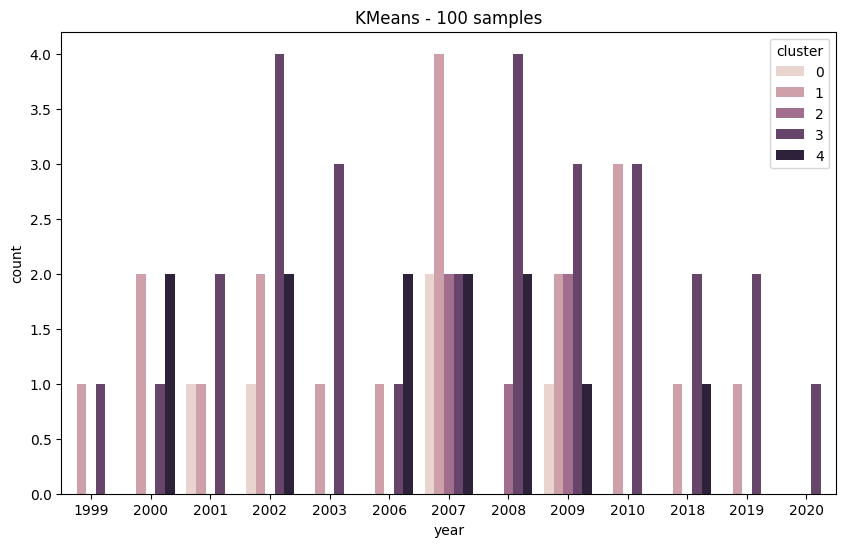

-------------------- KMEANS Cluster AVG ----------------- 
         highlevel_danceability_probability  highlevel_gender_probability  \
cluster                                                                     
0                                      0.68                         -0.45   
1                                     -0.84                          0.16   
2                                      0.57                          0.58   
3                                      0.35                         -0.27   
4                                      0.18                          0.28   

         highlevel_genre_dortmund_probability  \
cluster                                         
0                                       -0.17   
1                                       -0.19   
2                                       -0.08   
3                                        0.34   
4                                       -0.44   

         highlevel_genre_electronic_probability  \
cluste

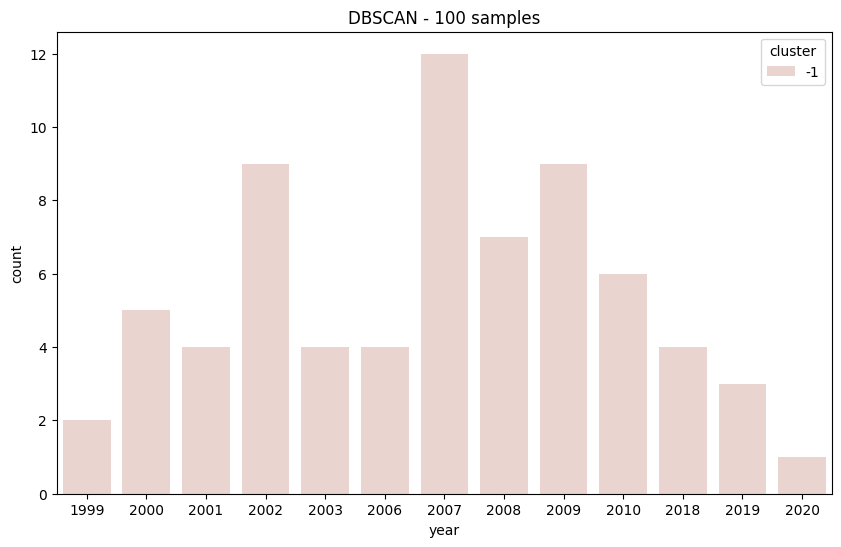

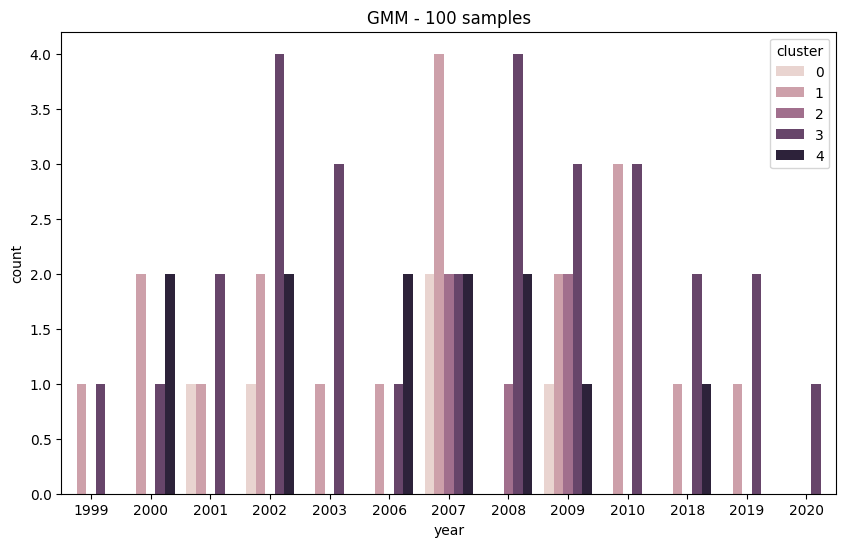


 <=== Running for Sample Size: 1000 ===>
SAMPLE leewks like    highlevel_danceability_probability highlevel_danceability_value  \
0                            0.989377                not_danceable   
1                            0.657998                not_danceable   

   highlevel_gender_probability highlevel_gender_value  \
0                      0.635980                 female   
1                      0.860416                 female   

   highlevel_genre_dortmund_probability highlevel_genre_dortmund_value  \
0                              0.481223                    folkcountry   
1                              0.463538                     electronic   

   highlevel_genre_electronic_probability highlevel_genre_electronic_value  \
0                                0.937497                          ambient   
1                                0.673582                          ambient   

   highlevel_genre_rosamerica_probability highlevel_genre_rosamerica_value  \
0                

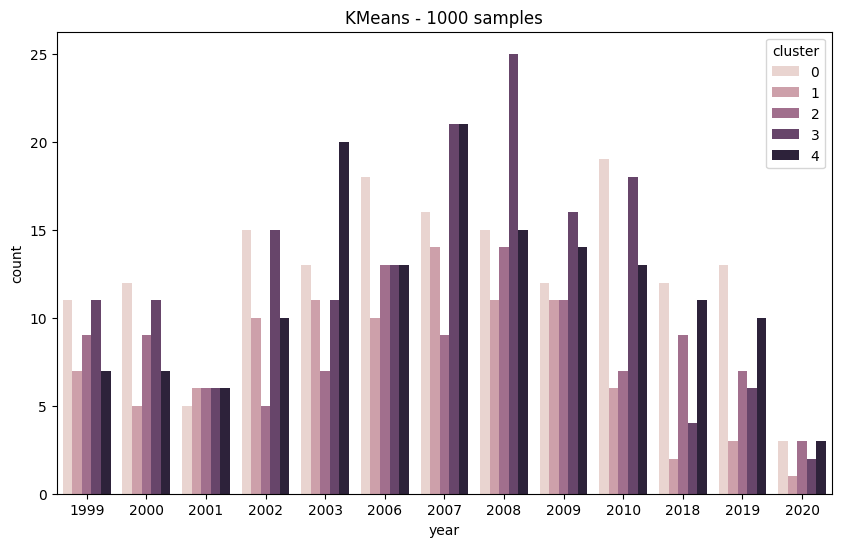

-------------------- KMEANS Cluster AVG ----------------- 
         highlevel_danceability_probability  highlevel_gender_probability  \
cluster                                                                     
0                                     -0.11                          0.16   
1                                      0.63                         -0.76   
2                                     -1.00                          0.42   
3                                      0.43                         -0.17   
4                                      0.17                          0.20   

         highlevel_genre_dortmund_probability  \
cluster                                         
0                                       -0.11   
1                                        0.60   
2                                       -0.22   
3                                       -0.36   
4                                        0.17   

         highlevel_genre_electronic_probability  \
cluste

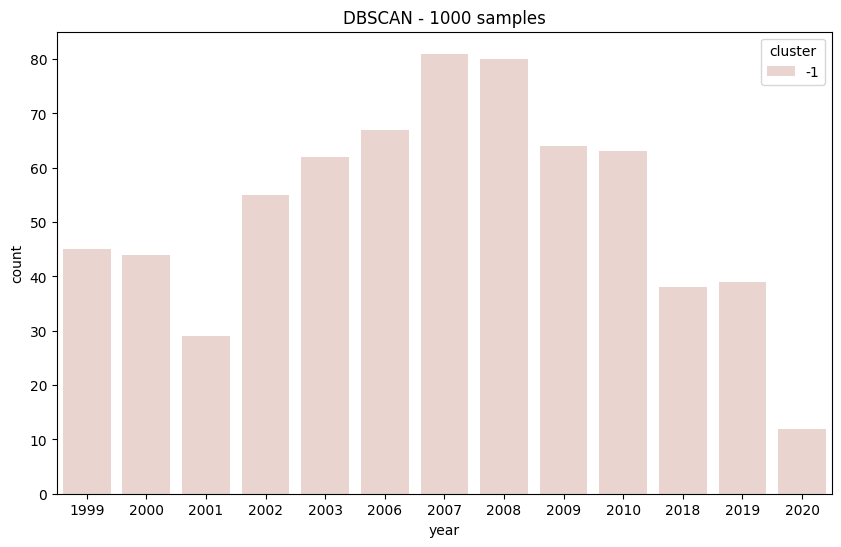

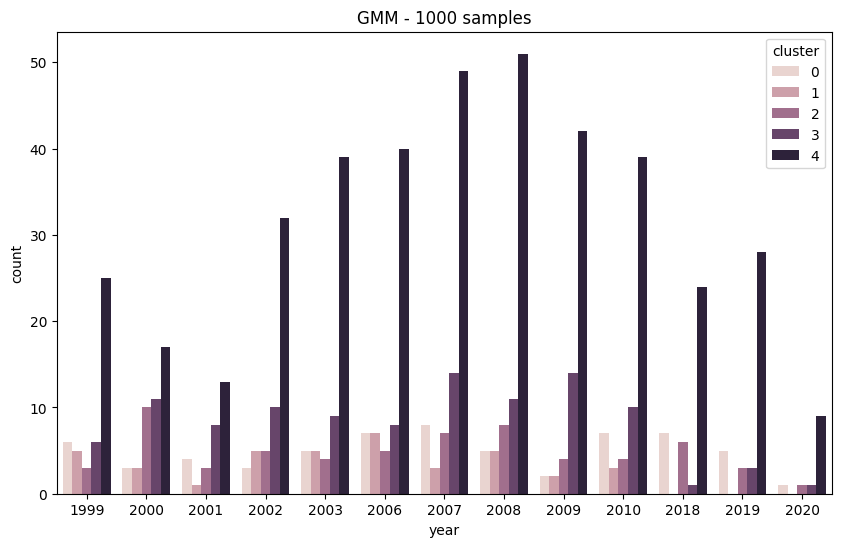


 <=== Running for Sample Size: 10000 ===>
SAMPLE leewks like    highlevel_danceability_probability highlevel_danceability_value  \
0                            0.989377                not_danceable   
1                            0.657998                not_danceable   

   highlevel_gender_probability highlevel_gender_value  \
0                      0.635980                 female   
1                      0.860416                 female   

   highlevel_genre_dortmund_probability highlevel_genre_dortmund_value  \
0                              0.481223                    folkcountry   
1                              0.463538                     electronic   

   highlevel_genre_electronic_probability highlevel_genre_electronic_value  \
0                                0.937497                          ambient   
1                                0.673582                          ambient   

   highlevel_genre_rosamerica_probability highlevel_genre_rosamerica_value  \
0               

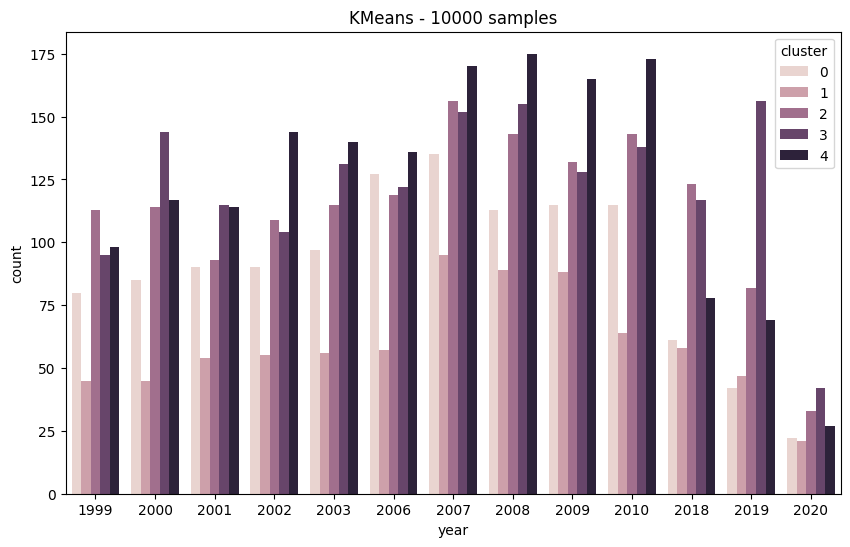

-------------------- KMEANS Cluster AVG ----------------- 
         highlevel_danceability_probability  highlevel_gender_probability  \
cluster                                                                     
0                                      0.60                         -0.72   
1                                      0.45                         -0.19   
2                                     -0.08                          0.24   
3                                     -0.77                          0.36   
4                                      0.22                          0.08   

         highlevel_genre_dortmund_probability  \
cluster                                         
0                                        0.55   
1                                       -0.14   
2                                        0.11   
3                                       -0.11   
4                                       -0.40   

         highlevel_genre_electronic_probability  \
cluste

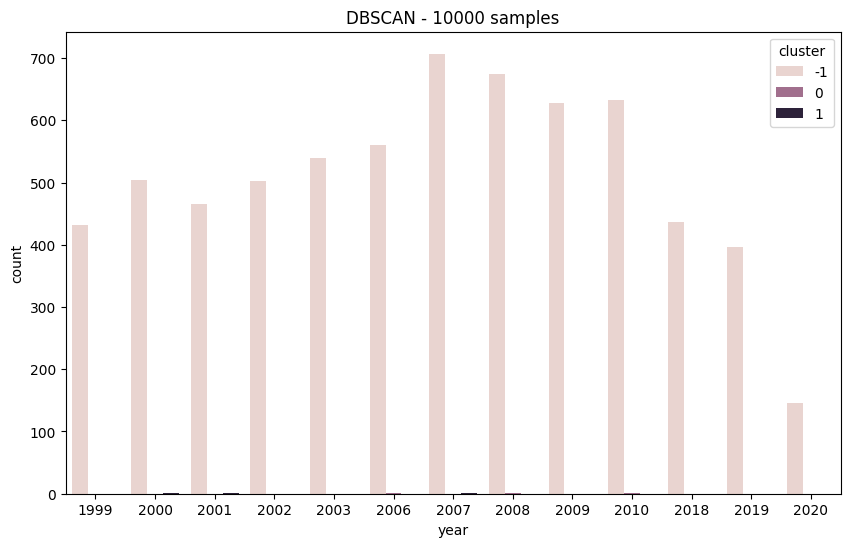

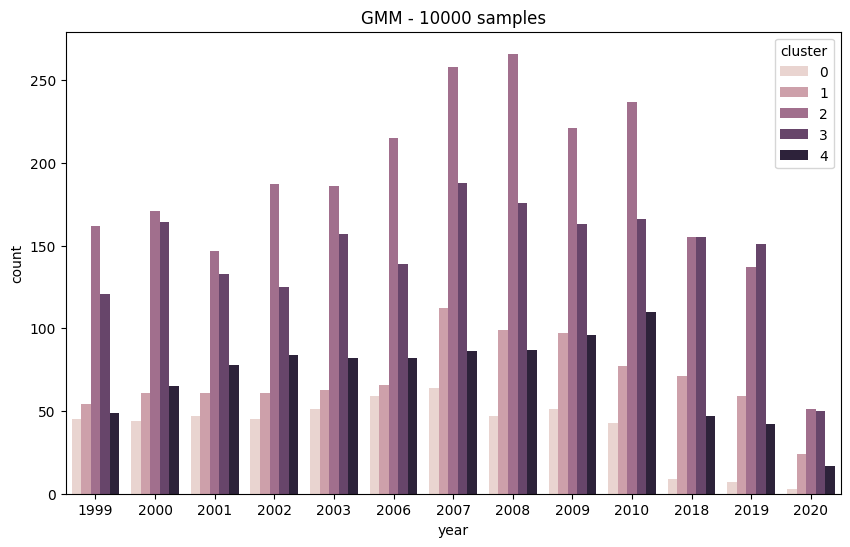

In [13]:
df_all = thread_read_and_clean(CSV_DIR, limit=50)  # trying 10 first csvs for now

for size in [100, 1000, 10000]:  # add 100000 if later
    print(f"\n <=== Running for Sample Size: {size} ===>")
    pipelinee(df_all, sample_size=size)

In [14]:
# one hot encoding for the general genres
# use stephanie's regex function

# music map

# imputation does not work here

# okkkk


# lets see monnth to month analysis in the 18 or so month period of the recession
# lets get a several more years tbh get a feel for it